In [1]:
import os
import random
import time
import collections
import networkx as nx
import matplotlib.pyplot as plt

from innvariant_dgl.dataset import ConstructionSequenceDataset, construction_sequence_to_graph
from tqdm import tqdm

In [6]:
file_generated_sequences = 'deepgg-model-t1588676286-generated.pkl'  # deepgg-model-t1588715718-generated.pkl
#file_generated_sequences = 'deepgg-model-t1588715718-generated.pkl'

In [7]:
dataset = ConstructionSequenceDataset.from_pickle_file(file_generated_sequences)

In [8]:
len(dataset)

1000

In [9]:
graphs = [construction_sequence_to_graph(seq) for seq in dataset]

In [15]:
def count_degree(ds_construction_sequence):
    degree_count = collections.Counter()

    for cur_graph in [construction_sequence_to_graph(seq) for seq in ds_construction_sequence]:
        degree_sequence = sorted([d for n, d in cur_graph.degree()], reverse=True)
        degree_count.update(degree_sequence)
    return degree_count

In [16]:
def plot_count(count: collections.Counter, title='', label=''):
    deg, cnt = zip(*count.items())
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title('Histogram %s' % title)
    plt.ylabel('Count')
    plt.xlabel(label)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    plt.show()

In [17]:
degree_count = count_degree(dataset)

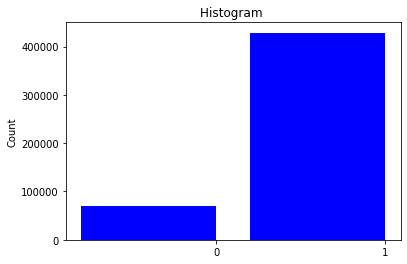

In [18]:
plot_count(degree_count)

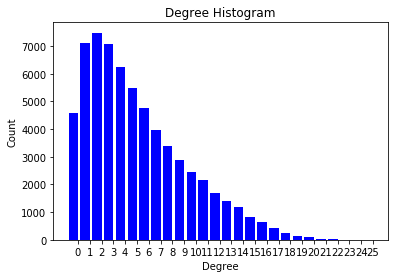

In [42]:
plot_degree_count(degree_count)

In [19]:
ds_ba_graphs = ConstructionSequenceDataset.from_pickle_file('test-medium.pkl')

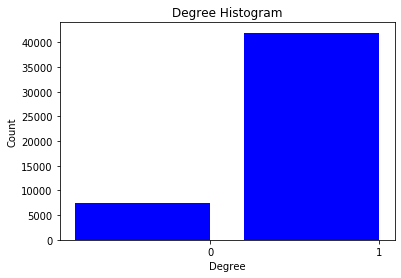

In [20]:
ba_graphs = [construction_sequence_to_graph(seq) for seq in ds_ba_graphs]

ba_degree_count = collections.Counter()
for cur_graph in ba_graphs:
    degree_sequence = sorted([d for n, d in cur_graph.degree()], reverse=True)
    ba_degree_count.update(degree_sequence)
    
plot_degree_count(ba_degree_count)

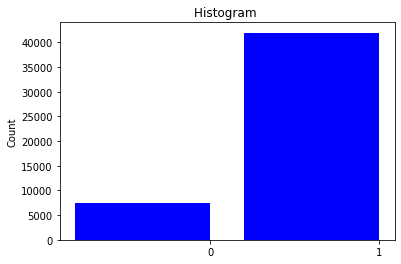

In [23]:
plot_count(count_degree(ds_ba_graphs))

# Looking into model

In [24]:
import torch
from innvariant_dgl.deepgg import DeepGG

Using backend: pytorch


In [26]:
pretrained_model_file = 'deepgg-model-t1588676286.pth'  # deepgg-model-t1588715718.pth
minimum_vertices = 50
device = torch.device('cuda:{d_idx}'.format(d_idx=torch.randint(torch.cuda.device_count(), (1,)).item()) if torch.cuda.is_available() else 'cpu')
print('Using device <{dev}>'.format(dev=device))
model = DeepGG(v_max=100, node_hidden_size=16, num_prop_rounds=2)
model.v_min = minimum_vertices
pretrained_model_state = torch.load(pretrained_model_file)
model.load_state_dict(pretrained_model_state)
model.to(device)

Using device <cuda:0>


DeepGG(
  (_graph_embed): GraphEmbed(
    (node_gating): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
      (1): Sigmoid()
    )
    (node_to_graph): Linear(in_features=16, out_features=32, bias=True)
    (_new_node_gating): Sequential(
      (0): Linear(in_features=16, out_features=7, bias=True)
      (1): Sigmoid()
    )
    (_conv): GraphConv(in=7, out=32, normalization=both, activation=None)
  )
  (_graph_prop): GraphProp(
    (message_funcs): ModuleList(
      (0): Linear(in_features=48, out_features=32, bias=True)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
    (node_update_funcs): ModuleList(
      (0): GRUCell(32, 16)
      (1): GRUCell(32, 16)
    )
  )
  (_choose_node): ChooseNodeAction(
    (_choose_node): Linear(in_features=64, out_features=1, bias=True)
  )
  (_node_type_embed): Embedding(2, 16)
  (_initialize_hv): Linear(in_features=32, out_features=16, bias=True)
  (_initialize_edge): Linear(in_features=32, out_features

In [27]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

10271

In [28]:
[p.shape for p in model.parameters()]

[torch.Size([1, 16]),
 torch.Size([1]),
 torch.Size([32, 16]),
 torch.Size([32]),
 torch.Size([7, 16]),
 torch.Size([7]),
 torch.Size([7, 32]),
 torch.Size([32]),
 torch.Size([32, 48]),
 torch.Size([32]),
 torch.Size([32, 48]),
 torch.Size([32]),
 torch.Size([48, 32]),
 torch.Size([48, 16]),
 torch.Size([48]),
 torch.Size([48]),
 torch.Size([48, 32]),
 torch.Size([48, 16]),
 torch.Size([48]),
 torch.Size([48]),
 torch.Size([1, 64]),
 torch.Size([1]),
 torch.Size([2, 16]),
 torch.Size([16, 32]),
 torch.Size([16]),
 torch.Size([16, 32]),
 torch.Size([16]),
 torch.Size([3, 32]),
 torch.Size([3]),
 torch.Size([3, 48]),
 torch.Size([3])]